In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mltest/test.csv
/kaggle/input/mltraincsv/MLtrain.csv


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# path to file you will use for predictions

train_df_path= '../input/mltraincsv/MLtrain.csv'
test_df_path = '../input/mltest/test.csv'

import numpy as np 
import math as math_stl

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371  # km
    dlat = math_stl.radians(lat2 - lat1)
    dlon = math_stl.radians(lon2 - lon1)
    a = math_stl.sin(dlat / 2) * math_stl.sin(dlat / 2) + math_stl.cos(math_stl.radians(lat1)) * math_stl.cos(math_stl.radians(lat2)) * math_stl.sin(dlon / 2) * math_stl.sin(dlon / 2)
    c = 2 * math_stl.atan2(math_stl.sqrt(a), math_stl.sqrt(1 - a))
    d = radius * c
    return d

# Preprocessing

In [3]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

train_df['drop_time'] = pd.to_datetime(train_df['drop_time'], errors='coerce')
train_df['pickup_time'] = pd.to_datetime(train_df['pickup_time'], errors='coerce')
test_df['drop_time'] = pd.to_datetime(test_df['drop_time'], errors='coerce')
test_df['pickup_time'] = pd.to_datetime(test_df['pickup_time'], errors='coerce')

train_df['trip_time'] = train_df.drop_time - train_df.pickup_time
test_df['trip_time'] = test_df.drop_time - test_df.pickup_time

train_df['trip_time'] = train_df['trip_time'].dt.total_seconds()
test_df['trip_time'] = test_df['trip_time'].dt.total_seconds()

train_df['distance'] = 0.0
test_df['distance'] = 0.0

for index, row in train_df.iterrows():
    train_df.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])

for index, row in test_df.iterrows():
    test_df.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])
    
train_df['fare_per_min'] = train_df['fare']/train_df['duration']
test_df['fare_per_min'] = test_df['fare']/test_df['duration']

train_df['fare_per_km'] = train_df['fare']/train_df['distance']
test_df['fare_per_km'] = test_df['fare']/test_df['distance']

train_df['speed'] = train_df['distance']/train_df['duration']
test_df['speed'] = test_df['distance']/test_df['duration']

train_df['additional_fare_per_km'] = train_df['additional_fare']/train_df['distance']
test_df['additional_fare_per_km'] = test_df['additional_fare']/test_df['distance']

train_df['travelling_per_rupee'] = (train_df['trip_time']-train_df['meter_waiting'])/train_df['fare']
test_df['travelling_per_rupee'] = (test_df['trip_time']-test_df['meter_waiting'])/test_df['fare']

train_df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,drop_lon,fare,label,trip_time,distance,fare_per_min,fare_per_km,speed,additional_fare_per_km,travelling_per_rupee
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,79.8783,270.32,correct,840.0,5.092770,0.324125,53.079170,0.006106,2.061746,2.900266
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,79.8923,197.85,correct,780.0,3.168058,0.250126,62.451516,0.004005,3.314334,3.704827
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,79.9146,301.64,correct,1080.0,6.305395,0.277498,47.838398,0.005801,1.665241,3.315210
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,79.8971,82.30,correct,600.0,0.861946,0.137625,95.481606,0.001441,12.181736,3.997570
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,79.9290,358.39,correct,1020.0,8.147782,NaN,43.986203,NaN,NaN,NaN


# Feature Selection and Encoding Y

In [4]:

features = ['travelling_per_rupee', 'speed', 'additional_fare_per_km',
            'fare_per_km', 'fare_per_min','meter_waiting','trip_time','duration',
             'meter_waiting_fare', 'meter_waiting_till_pickup', 'distance', 'fare']

y = train_df[["label"]]

x = (train_df[features]).fillna(0)
x_test = (test_df[features]).fillna(0)

# Encode labels
labels = {"label": {"correct": 1, "incorrect": 0}}
new_y = y.replace(labels)
print ('x is ',x.head())
print ('x test is ',x.head())
print ('y is ',new_y.head())
x.head()

x is     travelling_per_rupee     speed  additional_fare_per_km  fare_per_km  \
0              2.900266  0.006106                2.061746    53.079170   
1              3.704827  0.004005                3.314334    62.451516   
2              3.315210  0.005801                1.665241    47.838398   
3              3.997570  0.001441               12.181736    95.481606   
4              0.000000  0.000000                0.000000    43.986203   

   fare_per_min  meter_waiting  trip_time  duration  meter_waiting_fare  \
0      0.324125           56.0      840.0     834.0              0.0000   
1      0.250126           47.0      780.0     791.0              0.0000   
2      0.277498           80.0     1080.0    1087.0              0.0000   
3      0.137625          271.0      600.0     598.0             15.6638   
4      0.000000            0.0     1020.0       0.0              0.0000   

   meter_waiting_till_pickup  distance    fare  
0                       64.0  5.092770  270.32  


,travelling_per_rupee,speed,additional_fare_per_km,fare_per_km,fare_per_min,meter_waiting,trip_time,duration,meter_waiting_fare,meter_waiting_till_pickup,distance,fare
0,2.900266,0.006106,2.061746,53.079170,0.324125,56.0,840.0,834.0,0.0000,64.0,5.092770,270.32
1,3.704827,0.004005,3.314334,62.451516,0.250126,47.0,780.0,791.0,0.0000,134.0,3.168058,197.85
2,3.315210,0.005801,1.665241,47.838398,0.277498,80.0,1080.0,1087.0,0.0000,61.0,6.305395,301.64
3,3.997570,0.001441,12.181736,95.481606,0.137625,271.0,600.0,598.0,15.6638,68.0,0.861946,82.30
4,0.000000,0.000000,0.000000,43.986203,0.000000,0.0,1020.0,0.0,0.0000,0.0,8.147782,358.39


In [5]:
combined_data = pd.concat([x,new_y],axis=1)

from scipy import stats
import numpy as np
z = stats.zscore(combined_data)
z = np.abs(stats.zscore(combined_data))

threshold =3.04
outliers=np.where(z > threshold)
print (combined_data.shape)
print(len(set(outliers[0])))
cleaned_combined_data = combined_data.drop(outliers[0])
print (cleaned_combined_data.shape)

cleaned_combined_data.head()

# Redefine x and y
without_outlier_y = cleaned_combined_data["label"]
without_outlier_x = (cleaned_combined_data[features])

# Normalize the data
#normalized_x=(without_outlier_x-without_outlier_x.min())/(without_outlier_x.max()-without_outlier_x.min())
#normalized_x_test=(x_test-x_test.min())/(x_test.max()-x_test.min())

normalized_x = without_outlier_x
y = without_outlier_y
normalized_x_test = x_test

print('normalized x is ',normalized_x.head())
print('normalized x test is ',normalized_x_test.head())
print('y is ',y.head())
normalized_x.head()

(17176, 13)
129
(17047, 13)
normalized x is     travelling_per_rupee     speed  additional_fare_per_km  fare_per_km  \
0              2.900266  0.006106                2.061746    53.079170   
1              3.704827  0.004005                3.314334    62.451516   
2              3.315210  0.005801                1.665241    47.838398   
3              3.997570  0.001441               12.181736    95.481606   
4              0.000000  0.000000                0.000000    43.986203   

   fare_per_min  meter_waiting  trip_time  duration  meter_waiting_fare  \
0      0.324125           56.0      840.0     834.0              0.0000   
1      0.250126           47.0      780.0     791.0              0.0000   
2      0.277498           80.0     1080.0    1087.0              0.0000   
3      0.137625          271.0      600.0     598.0             15.6638   
4      0.000000            0.0     1020.0       0.0              0.0000   

   meter_waiting_till_pickup  distance    fare  
0         

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in subtract
  return (a - mns) / sstd
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


,travelling_per_rupee,speed,additional_fare_per_km,fare_per_km,fare_per_min,meter_waiting,trip_time,duration,meter_waiting_fare,meter_waiting_till_pickup,distance,fare
0,2.900266,0.006106,2.061746,53.079170,0.324125,56.0,840.0,834.0,0.0000,64.0,5.092770,270.32
1,3.704827,0.004005,3.314334,62.451516,0.250126,47.0,780.0,791.0,0.0000,134.0,3.168058,197.85
2,3.315210,0.005801,1.665241,47.838398,0.277498,80.0,1080.0,1087.0,0.0000,61.0,6.305395,301.64
3,3.997570,0.001441,12.181736,95.481606,0.137625,271.0,600.0,598.0,15.6638,68.0,0.861946,82.30
4,0.000000,0.000000,0.000000,43.986203,0.000000,0.0,1020.0,0.0,0.0000,0.0,8.147782,358.39


In [6]:
# #Hyper parameter tuning

# #RANDOM SEARCH 
# from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
# import xgboost as xgb

# params={
#  "eta"              : [0.05, 0.1,0.2,0.3],
#  "learning_rate"    : [ 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "subsample"        : [0.8, 0.9, 1.0],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.7, 0.8, 0.9, 1 ]
# }

# skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001)

# classifier=xgb.XGBClassifier (n_estimators=1000, objective='binary:logistic',
#                      silent=True, nthread=6, tree_method='hist', eval_metric='auc')
# random_search=RandomizedSearchCV(estimator = classifier, param_distributions = params, n_iter=10, scoring='roc_auc', n_jobs=4, cv=skf.split(x,y), verbose=3, random_state=1001)
# random_search.fit(x,new_y)
# random_search.best_estimator_

In [7]:
import xgboost

model = xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.05,
              eval_metric='auc', gamma=0.4, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.02,
              max_delta_step=0, max_depth=6, min_child_weight=7, missing=None,
              monotone_constraints=None, n_estimators=800, n_jobs=6, nthread=6,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=0.8, tree_method='hist', validate_parameters=False,verbosity=None)

In [8]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
score=cross_val_score(model, normalized_x, y)
print("Mean cross validation score:%f"%score.mean())

kfold = StratifiedKFold(n_splits=10)
kf_cv_scores = cross_val_score(model,normalized_x, y, cv=kfold)
print("K-fold CV average score: %f" % kf_cv_scores.mean())


Mean cross validation score:0.954127
K-fold CV average score: 0.954244


CPU times: user 11.7 s, sys: 5.16 s, total: 16.9 s
Wall time: 4.25 s


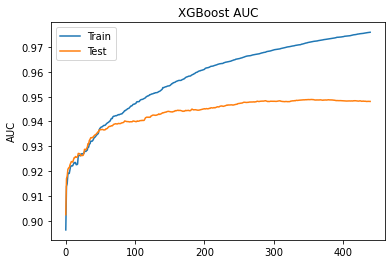

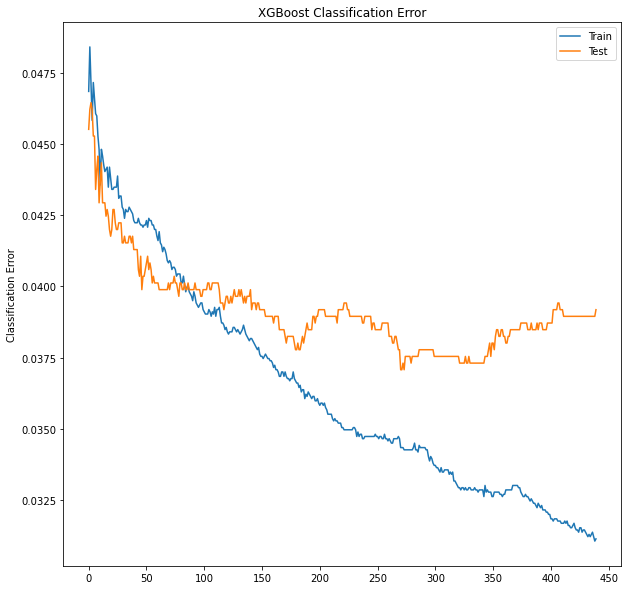

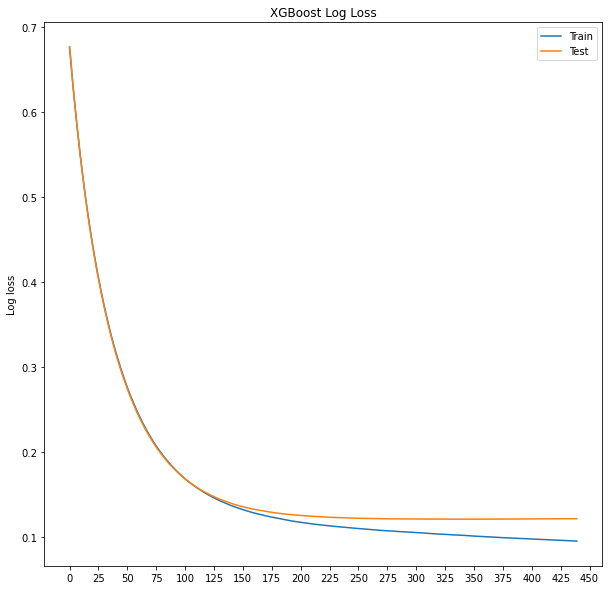

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import matplotlib.ticker as ticker
%matplotlib inline

train_X, val_X, train_y, val_y = train_test_split(normalized_x, y, random_state=1)

eval_set = [(train_X, train_y), (val_X, val_y)]
eval_metric = ['error','auc','logloss']
%time model.fit(train_X, train_y,  early_stopping_rounds=100, eval_set=eval_set, eval_metric=eval_metric, verbose=False)

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

fig, ax = pyplot.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
pyplot.show()

fig, ax = pyplot.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log loss')
pyplot.title('XGBoost Log Loss')
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
pyplot.show()


Confusion Matrix
[[ 256  119]
 [  40 3847]]


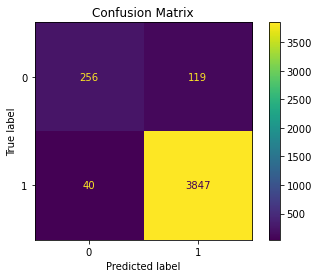

       travelling_per_rupee     speed  additional_fare_per_km  fare_per_km  \
9534               3.435994  0.005332                1.436427    51.082083   
9204               3.996697  0.001890                2.170509    82.599224   
12147             28.615514  0.000735                7.089735    48.135927   
3877               3.413118  0.003936                3.911627    59.922395   
2838               3.466205  0.002220               13.361603   124.822822   

       fare_per_min  meter_waiting  trip_time  duration  meter_waiting_fare  \
9534       0.272356           97.0     1380.0    1371.0            0.000000   
9204       0.156147          983.0     2580.0    2559.0           56.861106   
12147      0.035380            0.0     2040.0    2015.0            0.000000   
3877       0.235850          111.0      660.0     682.0            6.471300   
2838       0.277090           20.0      360.0     354.0            1.166000   

       meter_waiting_till_pickup  distance    fare  
953

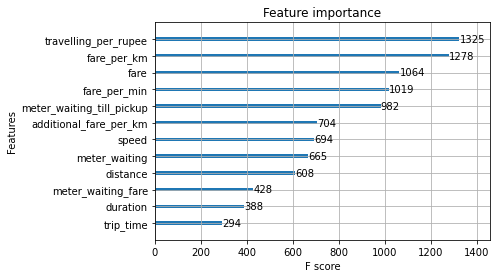

In [10]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(model, val_X, val_y,values_format='')

title= 'Confusion Matrix'                            
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)
pyplot.show()

print (train_X.head())
from xgboost import plot_importance

plot_importance(model)
pyplot.show()


In [11]:
from sklearn.metrics import fbeta_score,roc_auc_score

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    accuracy = accuracy_score(test_labels, predictions)
    f1beta = fbeta_score(test_labels,predictions, average='macro', beta=1)
    auc_roc = roc_auc_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy:%f'%accuracy)
    print('Mean Squared Error : %.4f' % mse)
    print('Root MSE : %.4f' % rmse)
    print('F1 Beta Score : %.5f' % f1beta)
    print('ROC AUC Score : %.5f' % auc_roc)
    
evaluate(model, val_X, val_y)


Model Performance
Accuracy:0.962694
Mean Squared Error : 0.0373
Root MSE : 0.1931
F1 Beta Score : 0.87140
ROC AUC Score : 0.83619


In [12]:
model.fit(normalized_x, y,eval_metric='auc')

predictions = model.predict(normalized_x_test)

from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H:%M:%S")
filename='new2-ml-submission'+ date_time+'.csv'
output = pd.DataFrame({'tripid': test_df.tripid, 'prediction': predictions})

output.to_csv(filename, index=False)
print(filename)

new2-ml-submission06_14_2020_14:45:34.csv
